In [17]:
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import (
    recall_score, precision_score, accuracy_score,
    cohen_kappa_score, confusion_matrix, average_precision_score, roc_auc_score
)
from scipy.spatial.distance import directed_hausdorff
from medpy.metric.binary import hd, assd, dc, jc
import pandas as pd

def load_masks_from_folder(folder_path):
    files = sorted(os.listdir(folder_path))
    masks = [imread(os.path.join(folder_path, file), as_gray=True) > 0.5 for file in files]
    return masks

# Evaluation function using medpy for each image
def evaluate_segmentation_metrics_medpy(gt_folder, pred_folder):
    gt_masks = load_masks_from_folder(gt_folder)
    pred_masks = load_masks_from_folder(pred_folder)

    metrics_per_image = []

    for i, (gt, pred) in enumerate(zip(gt_masks, pred_masks)):
        gt_flat = gt.flatten()
        pred_flat = pred.flatten()

        try:
            dice = dc(pred, gt)
            iou = jc(pred, gt)
            recall = recall_score(gt_flat, pred_flat)
            precision = precision_score(gt_flat, pred_flat)
            accuracy = accuracy_score(gt_flat, pred_flat)
            tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()
            specificity = tn / (tn + fp) if (tn + fp) else 0
            haus = hd(pred, gt)
            surface_dist = assd(pred, gt)
            kappa = cohen_kappa_score(gt_flat, pred_flat)
            ap = average_precision_score(gt_flat, pred_flat)
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue

        metrics_per_image.append({
            "Image Index": i,
            "Dice": dice,
            "IoU": iou,
            "Recall": recall,
            "Precision": precision,
            "Accuracy": accuracy,
            "Specificity": specificity,
            "Hausdorff Distance": haus,
            "ASSD": surface_dist,
            "Cohen's Kappa": kappa,
            "Average Precision": ap,
            "AUC": roc_auc_score(gt_flat, pred_flat)
        })
        
            #X "Dice": tk.BooleanVar(value=True),                            
            #X "IoU": tk.BooleanVar(value=True),
            #X "Accuracy": tk.BooleanVar(value=True),
            #X "Precision": tk.BooleanVar(value=True),
            #X "Recall": tk.BooleanVar(value=True),
            #X "Specificity": tk.BooleanVar(value=True),
            # "Fallout": tk.BooleanVar(value=True),
            # "Fnr": tk.BooleanVar(value=True),
            # "Volumetric similarity": tk.BooleanVar(value=True),
            # "AUC": tk.BooleanVar(value=True),
            # "GCE score": tk.BooleanVar(value=True),
            #X "Kappa": tk.BooleanVar(value=True),
            #X "AHD": tk.BooleanVar(value=True),
            #X "ASSD": tk.BooleanVar(value=True),
            # "DSC": tk.BooleanVar(value=True),
            # "Boundary IoU": tk.BooleanVar(value=True),
            #X "AP": tk.BooleanVar(value=True)

    return metrics_per_image

gt_folder_path = "C:/bakalarka/newbakalarka/program/img/test img/truth"
pred_folder_path = "C:/bakalarka/newbakalarka/program/img/test img/pred"

results = evaluate_segmentation_metrics_medpy(gt_folder_path, pred_folder_path)

# Print results per image
for r in results:
    print(r)
    



# Convert to DataFrame
df = pd.DataFrame(results)

# Save to Excel
output_path = "C:/bakalarka/newbakalarka/program/img/test img/segmentation_metrics.xlsx"
df.to_excel(output_path, index=False)

output_path


{'Image Index': 0, 'Dice': 0.732421875, 'IoU': 0.5778120184899846, 'Recall': 0.732421875, 'Precision': 0.732421875, 'Accuracy': 0.8662109375, 'Specificity': np.float64(0.9108072916666666), 'Hausdorff Distance': np.float64(7.280109889280518), 'ASSD': np.float64(4.300024840010701), "Cohen's Kappa": np.float64(0.6432291666666667), 'Average Precision': np.float64(0.6033363342285156), 'AUC': np.float64(0.8216145833333333)}
{'Image Index': 1, 'Dice': 0.583984375, 'IoU': 0.4124137931034483, 'Recall': 0.583984375, 'Precision': 0.583984375, 'Accuracy': 0.7919921875, 'Specificity': np.float64(0.861328125), 'Hausdorff Distance': np.float64(10.816653826391969), 'ASSD': np.float64(6.754553259569443), "Cohen's Kappa": np.float64(0.4453125), 'Average Precision': np.float64(0.4450416564941406), 'AUC': np.float64(0.72265625)}
{'Image Index': 2, 'Dice': 0.47265625, 'IoU': 0.309462915601023, 'Recall': 0.47265625, 'Precision': 0.47265625, 'Accuracy': 0.736328125, 'Specificity': np.float64(0.82421875), 'Ha

'C:/bakalarka/newbakalarka/program/img/test img/segmentation_metrics.xlsx'

In [16]:
from PIL import Image
import numpy as np

def generate_prediction_mask(gt_mask, mode='none'):
    """
    Generate prediction mask from ground truth.
    mode: 'full' = perfect overlap, 'none' = shifted, no overlap.
    """
    gt_array = np.array(gt_mask) > 0
    
    if mode == 'full':
        pred_array = gt_array.copy()
    elif mode == 'none':
        pred_array = np.roll(gt_array, shift=40, axis=1)
        pred_array[:, :40] = False  # cut off wrap-around
    else:
        raise ValueError("Mode must be 'full' or 'none'")
    
    pred_img = Image.fromarray((pred_array * 255).astype(np.uint8))
    return pred_img, pred_array

def create_overlay_from_masks(gt_mask, pred_array):
    """
    Create overlay image (RGB) with black background.
    - Green: ground truth only
    - Red: prediction only
    - Yellow: overlap
    """
    gt_array = np.array(gt_mask) > 0
    h, w = gt_array.shape

    overlay = np.zeros((h, w, 3), dtype=np.uint8)  # RGB only (black background)

    overlay[gt_array & ~pred_array] = [0, 255, 0]       # Green = GT only
    overlay[pred_array & ~gt_array] = [255, 0, 0]       # Red = Pred only
    overlay[gt_array & pred_array] = [255, 255, 0]      # Yellow = Overlap

    overlay_img = Image.fromarray(overlay, "RGB")
    return overlay_img

# --- Example usage ---

# Load your GT mask
gt_mask = Image.open(r"C:\bakalarka\newbakalarka\program\img\test img\truth\example_00_true.png").convert("L")

# Generate prediction (choose 'full' or 'none')
pred_img, pred_array = generate_prediction_mask(gt_mask, mode='none')

# Create overlay
overlay_img = create_overlay_from_masks(gt_mask, pred_array)

# Save results
pred_img.save("prediction_mask.png")
overlay_img.save("overlay_visual.png")



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique values in mask: [0 1]
Boundary points found: 252


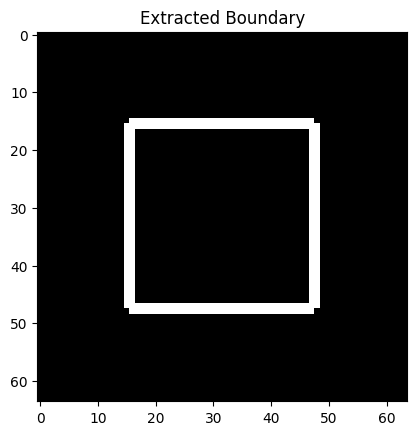

In [2]:
import numpy as np
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt

# Create a simple test mask (32x32 square)
mask = np.zeros((64, 64), dtype=np.uint8)
mask[16:48, 16:48] = 1

# Ensure it's binary
mask = (mask > 0).astype(np.uint8)

print(mask)

# Extract boundaries
boundary = find_boundaries(mask, mode='thick')
points = np.column_stack(np.where(boundary > 0))

print("Unique values in mask:", np.unique(mask))
print("Boundary points found:", len(points))

# Visualize to be sure
plt.imshow(boundary, cmap='gray')
plt.title("Extracted Boundary")
plt.show()

